# <center> Charger et prétraiter les images </center> 

**Source :** https://www.tensorflow.org/tutorials/load_data/images?hl=fr 

## Importations : 

In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

## Jeu de données

In [ ]:
# télécharger le jeu de données
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 8s 0us/step


In [ ]:
# nombre d'images
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


### Exemples d'images

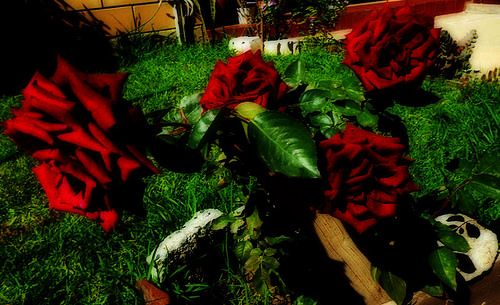

In [ ]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

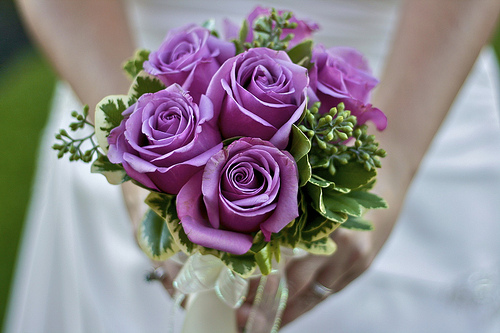

In [ ]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

## Charger des données à l'aide d'un utilitaire Keras

### Créer un ensemble de données

In [ ]:
# paramètres pour le chargeur 
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
# jeu d'entraînement
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
# jeu de validation
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
# noms des classes
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualisation des données

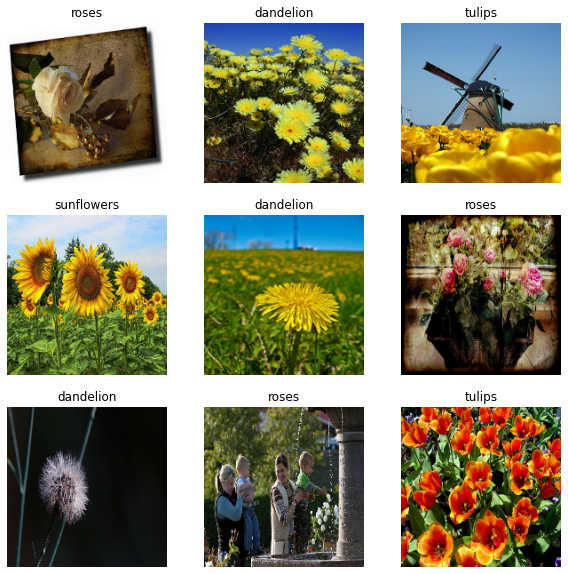

In [ ]:
# visualiser les 9 premières images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  # tenseur de 32 images de forme 180x180x3
  print(image_batch.shape)
  # tenseur : labels correspondants aux 32 images
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


## Standardiser les données

Les valeurs des canaux RVB sont dans la plage `[0, 255]` . Ce n'est pas idéal pour un réseau neuronal ; en général, vous devriez chercher à rendre vos valeurs d'entrée petites.

Ici, vous allez normaliser les valeurs pour qu'elles soient dans la plage `[0, 1]` en utilisant `tf.keras.layers.Rescaling` :

In [13]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [17]:
# # normalisation
# normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_ds))
# first_image = image_batch[0]
# # Notice the pixel values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image))

## Configurer l'ensemble de données pour les performances

In [26]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Entraînement du modèle 

In [14]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [15]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [16]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 169s 2s/step - loss: 1.3225 - accuracy: 0.4356 - val_loss: 1.0832 - val_accuracy: 0.5858
Epoch 2/3
92/92 [==============================] - 149s 2s/step - loss: 1.0347 - accuracy: 0.5978 - val_loss: 0.9841 - val_accuracy: 0.6158
Epoch 3/3
92/92 [==============================] - 156s 2s/step - loss: 0.8537 - accuracy: 0.6764 - val_loss: 0.9176 - val_accuracy: 0.6471


## Utiliser tf.data pour un contrôle plus fin

In [18]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

for f in list_ds.take(5):
  print(f.numpy())

b'/root/.keras/datasets/flower_photos/tulips/13539827514_79b60b6c22_n.jpg'
b'/root/.keras/datasets/flower_photos/roses/5979193298_639e877248.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/4927658421_7eed83bc95_m.jpg'
b'/root/.keras/datasets/flower_photos/daisy/6596277835_9f86da54bb.jpg'
b'/root/.keras/datasets/flower_photos/tulips/15082212714_ff87e8fcb1_m.jpg'


In [19]:
# noms des classes
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [21]:
# jeu de train/val
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


In [22]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [23]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [24]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [27]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [28]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  1


## Configurer l'ensemble de données pour les performances

In [29]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

## Visualisation

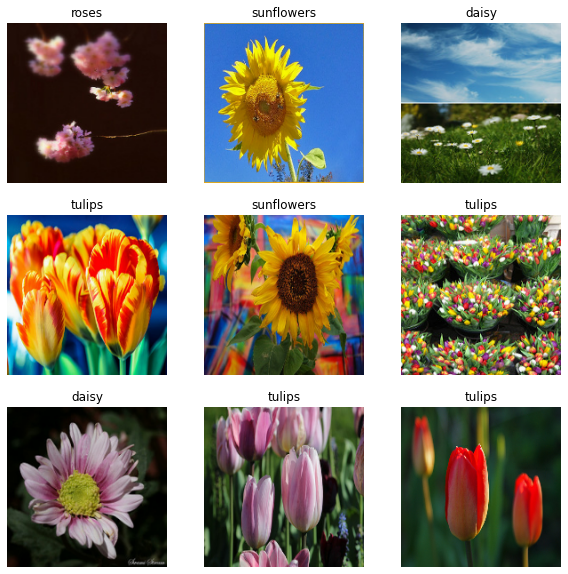

In [30]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

## Continuer la formation du modèle

In [31]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 152s 2s/step - loss: 0.7629 - accuracy: 0.7101 - val_loss: 0.8161 - val_accuracy: 0.6798
Epoch 2/3
92/92 [==============================] - 142s 2s/step - loss: 0.6237 - accuracy: 0.7663 - val_loss: 0.7377 - val_accuracy: 0.7030
Epoch 3/3
92/92 [==============================] - 146s 2s/step - loss: 0.4490 - accuracy: 0.8341 - val_loss: 0.8033 - val_accuracy: 0.7030


## Utiliser des ensembles de données TensorFlow

In [32]:
# téléchargement des données
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [33]:
# nombre de classes
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


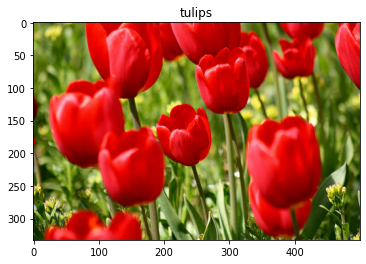

In [34]:
# afficher une image de l'ensemble des données
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

Comme précédemment, n'oubliez pas de regrouper, de mélanger et de configurer les ensembles d'entraînement, de validation et de test pour les performances :

In [35]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)